Импорт необходимых библиотек

In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from xgboost import XGBClassifier, DMatrix, plot_importance, plot_tree

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

pd.options.display.max_columns=100

Загрузка обучающего и тестового датасетов

In [2]:
train = pd.read_csv('data/catboost_train.csv')
test = pd.read_csv('data/catboost_test.csv')

In [3]:
cat_cols = [
    'purpose',
    'home_ownership',
    'subgrade'
]

for cat_cols in cat_cols:
    le = LabelEncoder()
    train[cat_cols] = le.fit_transform(train[cat_cols])
    test[cat_cols] = le.transform(test[cat_cols])

In [4]:
targ_cols = [i for i in train.columns if i not in ['def', 'id'] ]

X_train = train[targ_cols]
X_test = test[targ_cols]

y_train = train["def"]

In [5]:
targ_cols

['installment',
 'dti',
 'funded_amnt',
 'annual_inc',
 'emp_length',
 'term',
 'inq_last_6mths',
 'mths_since_recent_inq',
 'delinq_2yrs',
 'chargeoff_within_12_mths',
 'num_accts_ever_120_pd',
 'num_tl_90g_dpd_24m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'tot_hi_cred_lim',
 'delinq_amnt',
 'purpose',
 'subgrade',
 'home_ownership',
 'psk',
 'percent',
 'percent_per_year',
 'residual_dti',
 'loan_income_ratio',
 'additional_dti',
 'dti_ratio_min',
 'dti_ratio_max',
 'waste_to_installment_ratio',
 'is_first_loan',
 'is_not_sber_client',
 'even_salary',
 'even_installment',
 'is_emp_length_unknown',
 'is_dti_b_35',
 'is_common_amount',
 'funded_amnt_mod_1000',
 'funded_amnt_mod_500',
 'funded_amnt_mod_100',
 'funded_amnt_mod_10']

In [291]:


columns = [   
    'dti',
    'inq_last_6mths',
    'mths_since_recent_inq',
    'num_accts_ever_120_pd',
    'acc_open_past_24mths',
    'tot_hi_cred_lim',
    'purpose',
    'home_ownership',
    'psk',
    'percent',
    'loan_income_ratio',
    'is_emp_length_unknown',
    'funded_amnt_mod_100',   
]

cat_features = [
#     'purpose',
#     'home_ownership',
]

xgb_params = {
    'max_depth': 1,
    'learning_rate': 0.1,
    'reg_alpha': 1,
    'reg_lambda': 10,
    'n_estimators': 1500,
#     'min_child_weight': 40,
#     'min_gain_to_split': 1
}

skf = StratifiedKFold(n_splits=5, random_state=109, shuffle=True)
oof_result = pd.Series([0] * train.shape[0])
result = [0] * test.shape[0]
scores = []
for ind_trn, ind_test in skf.split(X_train, y_train):
    X_train_df = X_train[columns].iloc[ind_trn]
    X_valid_df = X_train[columns].iloc[ind_test]
    y_train_df = y_train.iloc[ind_trn]
    y_valid_df = y_train.iloc[ind_test]

    model = XGBClassifier(**xgb_params, )

    model.fit(
        X_train_df,  
        y_train_df,
        eval_set=[(X_valid_df, y_valid_df)],
        eval_metric='auc',
        verbose=100,
        early_stopping_rounds=150,
#         categorical_feature=cat_features,
    )
    result += model.predict_proba(test[columns])[:, 1:].flatten()/5
    scores.append(roc_auc_score(y_valid_df, model.predict_proba(X_valid_df)[:, 1]))
    oof_result.loc[ind_test] = model.predict_proba(X_valid_df)[:, 1]

    

[0]	validation_0-auc:0.61271
Will train until validation_0-auc hasn't improved in 150 rounds.
[100]	validation_0-auc:0.67523
[200]	validation_0-auc:0.67809
[300]	validation_0-auc:0.67963
[400]	validation_0-auc:0.68034
[500]	validation_0-auc:0.68077
[600]	validation_0-auc:0.68090
[700]	validation_0-auc:0.68089
[800]	validation_0-auc:0.68088
Stopping. Best iteration:
[658]	validation_0-auc:0.68099

[0]	validation_0-auc:0.61172
Will train until validation_0-auc hasn't improved in 150 rounds.
[100]	validation_0-auc:0.67932
[200]	validation_0-auc:0.68382
[300]	validation_0-auc:0.68627
[400]	validation_0-auc:0.68790
[500]	validation_0-auc:0.68852
[600]	validation_0-auc:0.68885
[700]	validation_0-auc:0.68920
[800]	validation_0-auc:0.68929
[900]	validation_0-auc:0.68938
[1000]	validation_0-auc:0.68933
[1100]	validation_0-auc:0.68946
[1200]	validation_0-auc:0.68950
[1300]	validation_0-auc:0.68956
[1400]	validation_0-auc:0.68955
Stopping. Best iteration:
[1251]	validation_0-auc:0.68959

[0]	vali

<Figure size 1080x720 with 0 Axes>

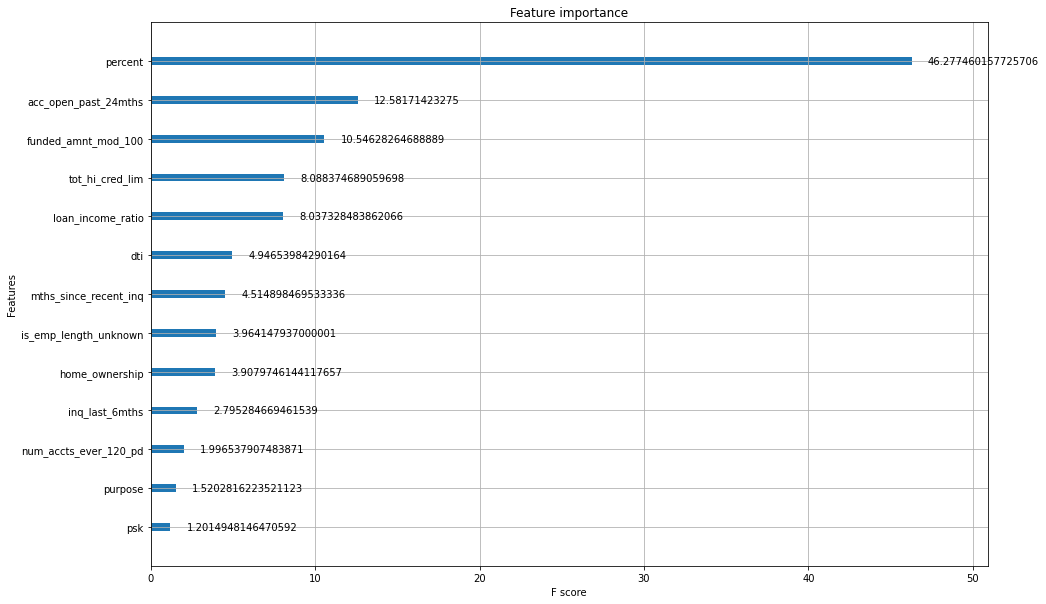

In [292]:
plt.figure(figsize=(15,10))
plot_importance(model, max_num_features=40, importance_type='gain')
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [293]:
#depth 4 0.05
np.mean(scores), np.std(scores), roc_auc_score(y_train, oof_result)

(0.6885613155510479, 0.004893838649392344, 0.688432405239852)

Применение модели к тестовой выборке

In [294]:
test['prob'] = result

Выгрузка решения для коммита в соревновании

In [295]:
test[['id', 'prob']].to_csv('xgb_submission.csv', index=False)

In [297]:
test[['id', 'prob']]

,id,prob
0,0,0.115384
1,1,0.146824
2,2,0.216910
3,3,0.174691
4,4,0.152055
...,...,...
29995,29995,0.128702
29996,29996,0.071632
29997,29997,0.231437
29998,29998,0.019282
